### 1. Momentum Backtesting class

Ham nay sai o dau do, sach viet ham chua chuan. 

In [9]:
import numpy as np 
import pandas as pd 


class MomVectorBacktester(object): 
    """Class for the vectorized backtesting of momentum-based trading strategies.
    
    Attributes:
    ==========
    symbol: str 
        RIC (financial instrument) to work with
    start: str
        start date for data selection 
    end: str 
        end date for data selection 
    amount: int, float 
        amount to be invested at the beginning 
    tc: float 
        proportional transaction costs (e.g., 0.5% = 0.005) per trade 
        
    Methods:
    =======
    get_data: 
        retrieves and prepares the base data set 
    run_strategy: 
        runs the backtest for the momentum-based strategy 
    plot_results:
        plots the performance of the strategy compared to the symbol 
    """
    
    def __init__(self, symbol, start, end, amount, tc): 
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None 
        self.get_data()       # call get_data() method in __init__ method 
        
    def get_data(self):
        """Retrieves and prepares data."""
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', 
                          index_col = 0, parse_dates = True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]      # location (index)
        raw.rename(columns = {self.symbol: 'price'}, inplace = True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw       # create a new attribute (DataFrame object)
        
    def run_strategy(self, momentum = 1): 
        """Backtests the trading strategy."""
        self.momentum = momentum 
        data = self.data.copy().dropna()  
        data['position'] = np.sign(data['return'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['return']
        
        # determine when a trade takes place 
        data.dropna(inplace = True)
        data['strategy'] = data['position'].diff().fillna(0) != 0 
        
        # subtract transaction costs from return when trade takes place 
        data['strategy'] -= self.tc                                                   # ????
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * data['strategy'].cumsum().apply(np.exp)     # ???    

        self.results = data

        # absolute performance of the strategy
        aperf = self.results['creturns'].iloc[-1]

        # out-/underperformance of strategy 
        operf = aperf - self.results['creturns'].iloc[-1]

        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        """Plots the cumulative performance of the trading strategy compared to the symbol."""
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title = title, figsize=(10, 6))

(13561.08, 0.0)
(13324.64, 0.0)
(13324.64, 0.0)


D:\anaconda3\lib\site-packages\matplotlib\ticker.py:2072: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


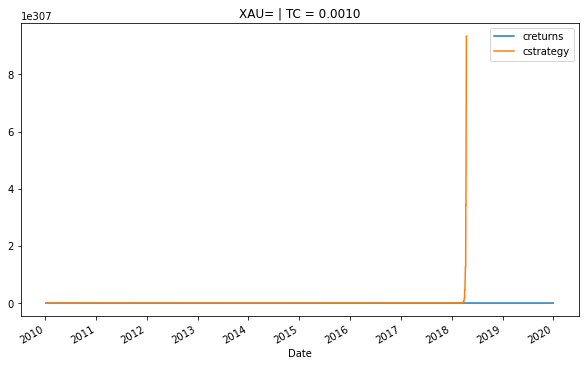

In [12]:
if __name__ == '__main__':
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31', 10000, 0.0)
    print(mombt.run_strategy())
    print(mombt.run_strategy(momentum = 2))
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31', 10000, 0.001)
    print(mombt.run_strategy(momentum = 2))
    
    mombt.plot_results()